In [1]:
from enum import Enum
import os
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Enum for CNN types
class CNN_TYPE(Enum):
    VGGNET = 1
    GOOGLENET = 2
    RESNET = 3
    MOBILENET = 4

current_cnn_type = CNN_TYPE.RESNET

# Function to get base model and preprocessing
def get_cnn_mode(type, image_shape):
    if type == CNN_TYPE.VGGNET:
        preprocess_input = tf.keras.applications.vgg16.preprocess_input
        model = tf.keras.applications.VGG16(input_shape=image_shape, include_top=False, weights='imagenet')
    elif type == CNN_TYPE.GOOGLENET:
        preprocess_input = tf.keras.applications.inception_v3.preprocess_input
        model = tf.keras.applications.InceptionV3(input_shape=image_shape, include_top=False, weights='imagenet')
    elif type == CNN_TYPE.RESNET:
        preprocess_input = tf.keras.applications.resnet50.preprocess_input
        model = tf.keras.applications.ResNet50(input_shape=image_shape, include_top=False, weights='imagenet')
    elif type == CNN_TYPE.MOBILENET:
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
        model = tf.keras.applications.MobileNetV2(input_shape=image_shape, include_top=False, weights='imagenet')
    else:
        preprocess_input = tf.keras.applications.vgg19.preprocess_input
        model = tf.keras.applications.VGG19(input_shape=image_shape, include_top=False, weights='imagenet')
    return preprocess_input, model

# Image shape
IMG_SHAPE = (224, 224, 3)
preprocess_input, base_model = get_cnn_mode(current_cnn_type, IMG_SHAPE)

# Training settings
LR = 1e-4
EPOCHS = 100
batch_size = 32
InputPath = r"C:\Users\hp\FaceMask_Dataset1"
Clasess = ["WithMask", "WithoutMask"]

# Load images and labels
print("[INFO] loading images...")
images = []
labels = []
for each_cls in Clasess:
    path = os.path.join(InputPath, each_cls)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)
        images.append(image)
        labels.append(each_cls)

# One-hot encode labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

images = np.array(images, dtype="float32")
labels = np.array(labels)

(X_train, X_test, Y_train, Y_test) = train_test_split(images, labels, test_size=0.20, stratify=labels, random_state=42)

# Data augmentation
data_augumentation = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Build the model head
model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Flatten(name="flatten")(model)
model = Dense(128, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(2, activation="softmax")(model)

model = Model(inputs=base_model.input, outputs=model)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

model.summary()

# Optional: Learning rate schedule (remove this block if not needed)
def lr_schedule(epoch):
    return LR * (1.0 / (1.0 + 0.01 * epoch))

callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Train the model
history = model.fit(
    data_augumentation.flow(X_train, Y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_test, Y_test),
    validation_steps=len(X_test) // batch_size,
    epochs=EPOCHS,
    callbacks=[callback]  # remove this if you're not using the learning rate schedule
)


[INFO] loading images...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,850,242 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.7542 - loss: 0.5726 - val_accuracy: 0.9825 - val_loss: 0.0855 - learning_rate: 1.0000e-04
Epoch 2/100
 1/49 ━━━━━━━━━━━━━━━━━━━━ 1:24 2s/step - accuracy: 0.9688 - loss: 0.1493

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 514ms/step - accuracy: 0.9688 - loss: 0.1493 - val_accuracy: 0.9825 - val_loss: 0.0838 - learning_rate: 9.9010e-05
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.9538 - loss: 0.1575 - val_accuracy: 0.9950 - val_loss: 0.0444 - learning_rate: 9.8039e-05
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 27s 517ms/step - accuracy: 1.0000 - loss: 0.0608 - val_accuracy: 0.9950 - val_loss: 0.0441 - learning_rate: 9.7087e-05
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.9838 - loss: 0.0803 - val_accuracy: 0.9950 - val_loss: 0.0319 - learning_rate: 9.6154e-05
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 28s 543ms/step - accuracy: 0.9688 - loss: 0.1032 - val_accuracy: 0.9950 - val_loss: 0.0317 - learning_rate: 9.5238e-05
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.9850 - loss: 0.0598 - val_accuracy: 0.9975 - val_loss: 0.0258 - learning_rate: 9.4340e-05
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 26s 509ms/step - accuracy: 1.00

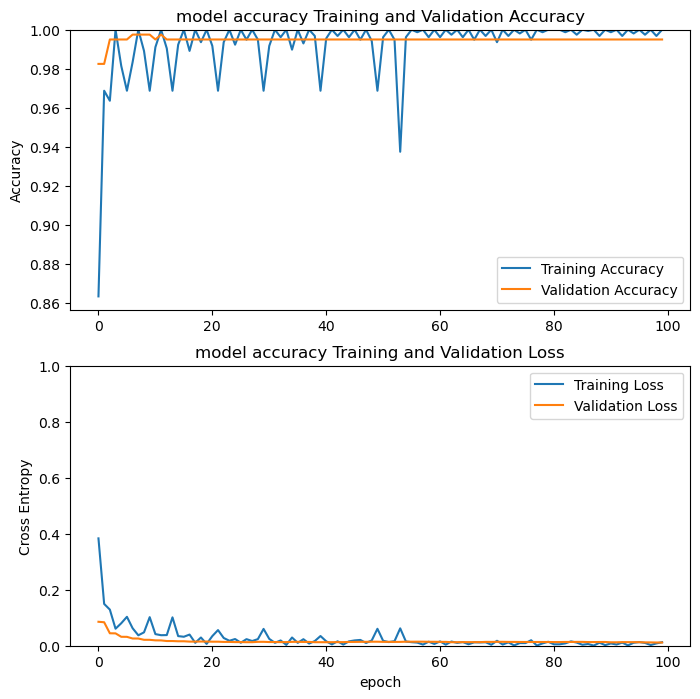

In [2]:
import matplotlib.pyplot as plt
def train_histor_view(history, name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label= 'Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(name + ' ' + 'Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title(name + ' ' + 'Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

train_histor_view(history, 'model accuracy')

In [3]:
from sklearn.metrics import classification_report

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=batch_size)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(Y_test.argmax(axis=1), predIdxs,target_names=lb.classes_))

[INFO] evaluating network...
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
              precision    recall  f1-score   support

    WithMask       0.99      0.99      0.99       200
 WithoutMask       0.99      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



Confusion matrix, without normalization
[[199   1]
 [  1 199]]


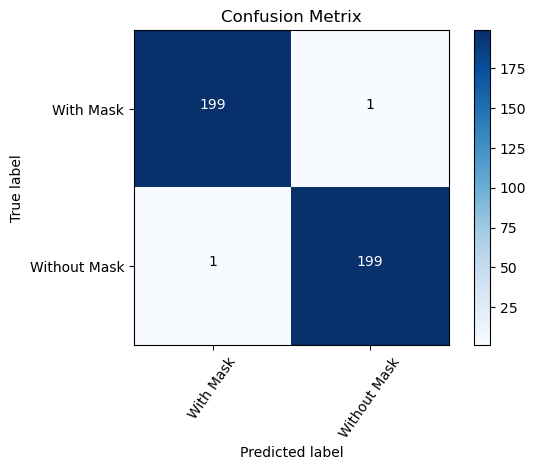

In [4]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(Y_test.argmax(axis=1), predIdxs)

cm_plot_label =['With Mask', 'Without Mask']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix')

In [5]:
def calculate_sensitivity_specificity(y_test, y_pred_test):
    # Note: More parameters are defined than necessary. 
    # This would allow return of other measures other than sensitivity and specificity
    
    # Get true/false for whether a breach actually occurred
    actual_pos = y_test == 1
    actual_neg = y_test == 0
    
    # Get true and false test (true test match actual, false tests differ from actual)
    true_pos = (y_pred_test == 1) & (actual_pos)
    false_pos = (y_pred_test == 1) & (actual_neg)
    true_neg = (y_pred_test == 0) & (actual_neg)
    false_neg = (y_pred_test == 0) & (actual_pos)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred_test == y_test)
    
    # Calculate sensitivity and specificity
    sensitivity = np.sum(true_pos) / np.sum(actual_pos)
    specificity = np.sum(true_neg) / np.sum(actual_neg)
    
    return sensitivity, specificity, accuracy

sensitivity, specificity, accuracy = calculate_sensitivity_specificity(Y_test.argmax(axis=1), predIdxs)
print ('Sensitivity:', sensitivity)
print ('Specificity:', specificity)
print ('Accuracy:', accuracy)

Sensitivity: 0.995
Specificity: 0.995
Accuracy: 0.995


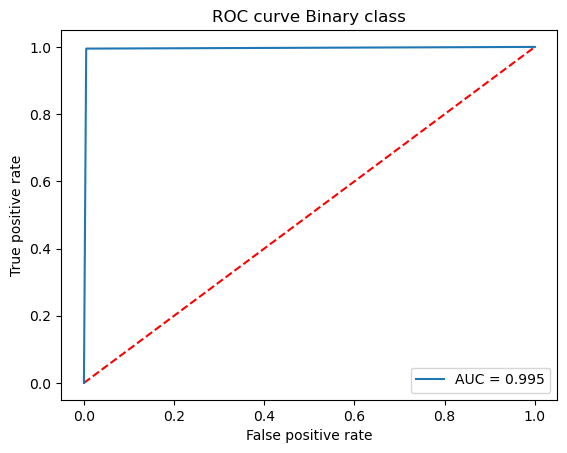

In [6]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(Y_test.argmax(axis=1), predIdxs)
false_positive_rate, true_positive_rate, threshold = roc_curve(Y_test.argmax(axis=1), predIdxs)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Binary class')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

In [7]:
# saving and loading the .h5 model

# save model
model.save('RESNET1.h5')
print('Model Saved!')

Model Saved!


In [8]:
model.save('my_model1.keras')
print('Model Saved!')

Model Saved!


In [9]:
from tensorflow.keras.models import load_model

# load model
savedModel=load_model('RESNET1.h5')
savedModel.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,850,244 (90.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2 (12.00 B)

In [9]:
##for face reconization section
import face_recognition
import os
import cv2
import pickle

dataset_path = "dataset"
encodings = []
names = []

print("[INFO] Encoding faces...")

for person_name in os.listdir(dataset_path):
    person_folder = os.path.join(dataset_path, person_name)
    
    if not os.path.isdir(person_folder):
        continue

    for image_name in os.listdir(person_folder):
        image_path = os.path.join(person_folder, image_name)
        image = cv2.imread(image_path)
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Detect face locations
        boxes = face_recognition.face_locations(rgb, model='hog')

        # Compute encodings
        encs = face_recognition.face_encodings(rgb, boxes)

        for enc in encs:
            encodings.append(enc)
            names.append(person_name)

# Save to pickle file
data = {"encodings": encodings, "names": names}
with open("face_encodings.pkl", "wb") as f:
    pickle.dump((encodings, names), f)

print(f"[INFO] Done. {len(encodings)} faces encoded.")


[INFO] Encoding faces...
[INFO] Done. 20 faces encoded.
